# Download DepecheMood from GitHub

In [15]:
!wget https://github.com/marcoguerini/DepecheMood/releases/download/v1.0/DepecheMood_V1.0.zip -O latest-DepecheMood.zip
!yes 2>/dev/null | unzip latest-DepecheMood.zip

SyntaxError: invalid syntax (<ipython-input-15-537542d5c5d8>, line 1)

In [283]:
ls DepecheMood_V1.0/

DepecheMood_freq.txt  DepecheMood_normfreq.txt  DepecheMood_tfidf.tsv  DepecheMood_tfidf.txt  README.txt


In [150]:
cat DepecheMood_V1.0/README.txt

This package contains the three versions of the Lexicon 'DepecheMood' as described in the paper: 

Staiano, J., & Guerini, M. (2014). "DepecheMood: a Lexicon for Emotion Analysis from Crowd-Annotated News". Proceedings of ACL-2014. 

Each version of DepecheMood is built starting from word-by-document matrices either using raw frequencies (DepecheMood_freq.txt), normalized frequencies (DepecheMood_normfreq.txt) or tf-idf (DepecheMood_tfidf.txt). 

The files are tab-separated; each row contains one Lemma#PoS followed by the scores for the following emotions: AFRAID, AMUSED, ANGRY, ANNOYED, DONT_CARE, HAPPY, INSPIRED, SAD.

This resource is freely available for research purposes. 



In [2]:
!sed -n '1p;100,120p' DepecheMood_V1.0/DepecheMood_tfidf.txt | cut  -f 1

Lemma#PoS
50#n
500#n
50th#a
55th#a
5th#a
6#n
60#n
60th#a
64th#a
65th#a
6th#a
7#n
70#n
70th#a
75th#a
78#n
7th#a
8#n
80#n
80th#a
85th#a


In [3]:
import nltk
import pandas as pd

In [398]:
lexicon = pd.DataFrame.from_csv("DepecheMood_V1.0/DepecheMood_normfreq.txt", sep="\t", index_col=False)
s = lexicon["Lemma#PoS"].str.split("#")
lexicon["Lemma"] = s.str[0]
lexicon["PoS"] = s.str[1]

In [399]:
s=lexicon.index.to_series()
s.str.contains("#", False).count() # All words contain # (POS tag)

0

In [400]:
lexicon["PoS"].unique() # According to the paper, there's verbs (v), nouns (n), adjectives (a) and adverbs (r)

array(['n', 'a', 'r', 'v'], dtype=object)

In [435]:
#lexicon[lexicon.groupby("Lemma")["PoS"].transform(len) > 1] # Getting lemmas with different PoS

In [436]:
lexdict = {}
header = []
with open("DepecheMood_V1.0/DepecheMood_tfidf.tsv") as f:
    header = f.next().strip().split()
    for l in f:
        temp = l.strip().split("\t")
        lexdict[temp[0]] = map(float, temp[1:])

# Compare performance

Pandas is great for analysis, but for sentiment analysis we need something that is quick at finding entries in the lexicon and calculating the values of each emotion. Hence, we need to compare pandas with a plain dictionary for this task.

In [438]:
import random
keys = lexdict.keys()
random.shuffle(keys)

In [439]:
def search_all(d):
    for i in keys:
        if i in d:
            ja = d[i][0] + d[i][1]
            
%timeit search_all(lexdict)
%timeit search_all(lexicon)

10 loops, best of 3: 16.9 ms per loop
10 loops, best of 3: 35.9 ms per loop


In [440]:
def search_all(d):
    for i in keys:
        if i in d:
            ja = 0
            for j in d[i]:
                ja += j
            
%timeit search_all(lexdict)
%timeit search_all(lexicon.ix[:, lexicon.columns - ["Lemma#PoS", "Lemma", "PoS"]])

10 loops, best of 3: 34.6 ms per loop
10 loops, best of 3: 39 ms per loop


Apparently, it is slightly better to use a python dictionary. Plus, we avoid dependencies.

# Sentiment Analysis

In [441]:
mapping = {
    
#CC - Coordinating conjunction
"CD": "n", # - Cardinal number
#DT - Determiner
#EX - Existential there
"FW": "n", # - Foreign word
#IN #- Preposition or subordinating conjunction
"JJ": "a", #- Adjective
"JJR": "a", # - Adjective, comparative
"JJS": "a", # - Adjective, superlative
#LS - List item marker
#MD - Modal
"NN": "n", # - Noun, singular or mass
"NNS": "n", # - Noun, plural
"NNP": "n", # - Proper noun, singular
"NNPS": "n", # - Proper noun, plural
#PDT - Predeterminer
#POS - Possessive ending
"PRP": "n", # - Personal pronoun
#PRP$ - Possessive pronoun (prolog version PRP-S)
"RB": "r", # - Adverb
"RBR": "r", # - Adverb, comparative
"RBS": "r", #- Adverb, superlative
#RP - Particle
#SYM - Symbol
#TO - to
#"UH": "n",  - Interjection
"VB": "v", # - Verb, base form
"VBD": "v", # - Verb, past tense
"VBG": "v", #- Verb, gerund or present participle
"VBN": "v", #- Verb, past participle
"VBP": "v",  #- Verb, non-3rd person singular present
"VBZ": "v", #- Verb, 3rd person singular present
#"WDT": "n" # - Wh-determiner
#"WP: - Wh-pronoun
#WP$ - Possessive wh-pronoun (prolog version WP-S)
"WRB": "r", # - Wh-adverb
    }
def simplify(tag):
    return mapping.get(tag, "n")

#Alternative:
#from nltk.tag.simplify import simplify_wsj_tag

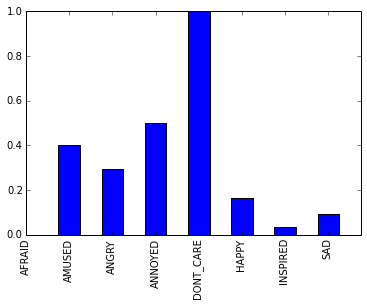

In [442]:
from nltk.tokenize import word_tokenize

ex = """ The father of a woman who died after a savage gang-rape in Delhi said he thought everyone should watch a documentary about the attack broadcast by the BBC but banned in India "If a man can speak like that in jail, imagine what he would say if he was walking free," said the father of the victim """
# ex = "The bombing killed 20 people and wounded more that 30."
def get_emotions(text):
    pos = nltk.pos_tag(word_tokenize(text))
    simply = [(i,simplify(j)) for i,j in pos]
#     print header
    total = None
    numwords = 0
    for (i,j) in simply:
        key = u"{}#{}".format(i,j)
        if key in lexdict:
            numwords += 1
            total = map(sum, zip(total, lexdict[key])) if total else lexdict[key]
#             print "{}\n- {}".format(key, lexdict[key])
#     print("The total is")
    minemotion = min(total)
    maxemotion = max(total)-minemotion
    total = map(lambda x: (x-minemotion)/maxemotion, total)
#     maxemotion = max(total)
#     total = map(lambda x: (x)/maxemotion, total)
#     print(total)
    return total
total = get_emotions(ex)
ind = np.arange(len(total))
width = 0.5
fig, ax = plt.subplots(1, 1)
ax.bar(ind, total, width=width)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(header[1:], rotation="vertical")
None

In [434]:
ex = """ The father of a woman who died after a savage gang-rape in Delhi said he thought everyone should watch a documentary about the attack broadcast by the BBC but banned in India "If a man can speak like that in jail, imagine what he would say if he was walking free," said the father of the victim """
def get_emotions_pd(text):
    df = pd.DataFrame(columns=header[1:])
    pos = nltk.pos_tag(word_tokenize(text))
    simply = [(i,simplify(j)) for i,j in pos]
    for (i,j) in simply:
        key = u"{}#{}".format(i,j)
        if key in lexdict:
            df.loc[key] = lexdict[key]
    return df

df = get_emotions_pd(ex)
df.mean()

AFRAID       0.112249
AMUSED       0.123500
ANGRY        0.138816
ANNOYED      0.116850
DONT_CARE    0.145988
HAPPY        0.116959
INSPIRED     0.112220
SAD          0.133418
dtype: float64